
# PINN (Physics Informed Neural Network)
$
\gdef\ddt#1{\frac{\mathrm{d} #1}{\mathrm{d}t}}
\gdef\d2dt2#1{\frac{\mathrm{d}^2#1}{\mathrm{d}t^2}}
$

Source: [Physics-Informed Neural Networks (PINNs) - An Introduction - Ben Moseley | The Science Circle](https://youtu.be/G_hIppUWcsc)

In this example we will see how to solve following ODE using neural network:

$$m \d2dt2{u} + \mu \ddt{u} + ku = 0$$

In order to validate solution, we have to compare it to analytics. Derivation is given below.

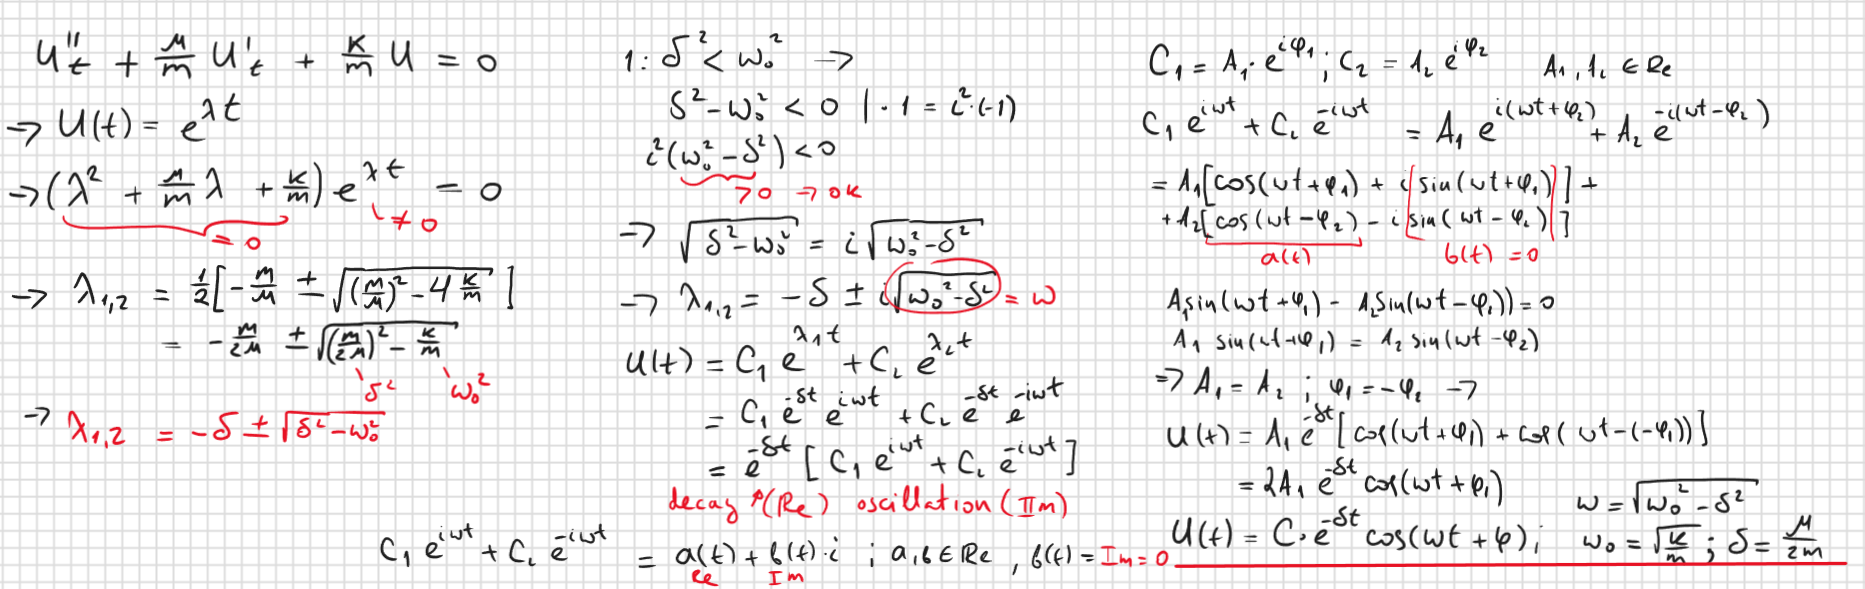

Good source: https://beltoforion.de/en/harmonic_oscillator/




## Calculate constants $C$ and $\phi$ for boundary contitions- $u(t=0) = 1$; $\ddt{u}(t=0)= 0$

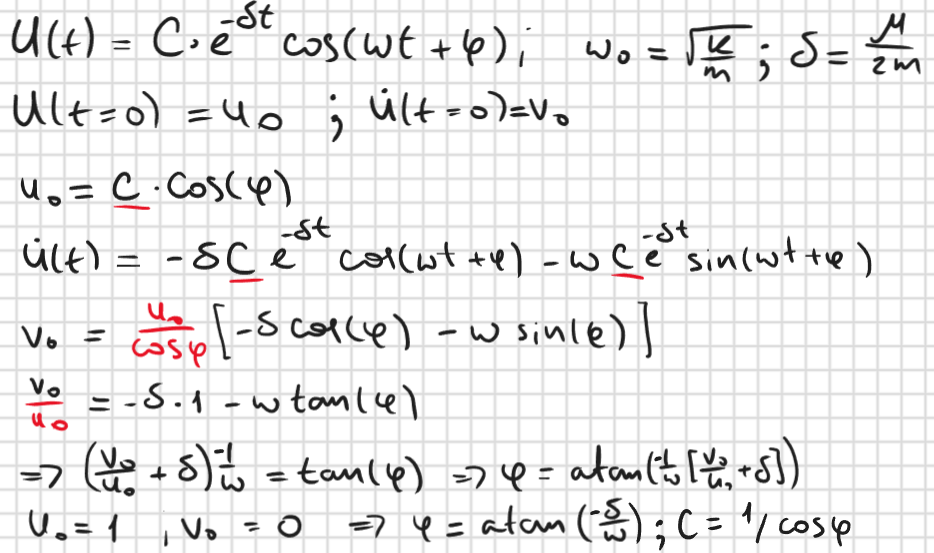

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from IPython import display

## Define $\omega$ and $\delta$ and plot analytic solution

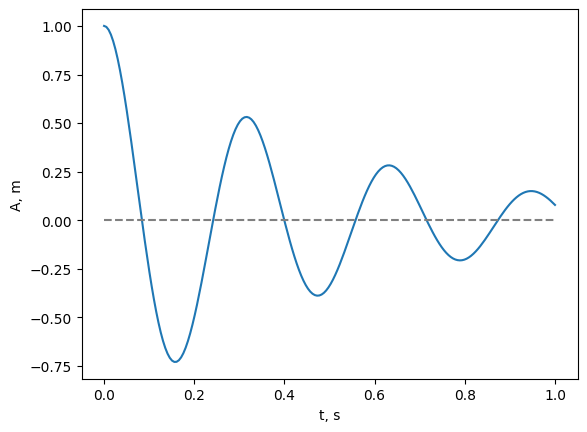

In [2]:
def anal(d,w0,t):
    assert d < w0, 'not an underdamped case!'
    #print(d,w0,t )
    d,w0, = torch.tensor(d),torch.tensor(w0)
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    C = 1/torch.cos(phi)
    sol = C * torch.exp(-d*t) * torch.cos(w*t + phi)
    return sol.clone().detach().squeeze().cpu()

d = 2; w0 = 20
ts = torch.linspace(0,1,200)
us = anal(d,w0,ts)
plt.plot(ts,us)
plt.hlines(0, 0,1, ls='--', colors='gray')
plt.xlabel('t, s')
plt.ylabel('A, m');

## Strategy
Network architecture is rather unconventional:
1. Input will be an array of times at which deflection of scillator will be sampled.
2. Output will be an array of deflection values of oscillator at given times.
***
Solution will be guided by enforcing:

1. Boundary conditions (BCs). BCs will be specified at $t=0$ for initial displacement and initial velocity;

$$\ddt{u} (t = 0)=1 ; u(t=0)=0 $$
***
and 

2. by minimizing residual (similarly to how its done in numerical models). i.e for all/any test time $t=t_i \in [0,1]$, governing differential equation should be satisfied:

    given that $u(t)$ is a true solution and $u^*(t)$ is an intermediate solution, we should minimize

    $$Loss_2 =\| \mathcal{L}u^* - \mathcal{L}u \| = \|\mathcal{L}u^* - 0\| = \|\mathcal{L}u^*\|$$

    In our case for samples at different times $Loss_2 =MSE(\mathcal{L}[u^*])=\frac{1}{N}\sum_{i}^{N} (\mathcal{L}[u^*(t_i)])^2$

## Define a model

In [3]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUPUT, N_HIDDEN, N_LAYERS) -> None:
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
           nn.Linear(N_INPUT,N_HIDDEN),
           activation()
        )
        self.fch = nn.Sequential(
            *[nn.Linear(N_HIDDEN,N_HIDDEN),activation()]*(N_LAYERS-1)
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUPUT)

    def forward(self,x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    
torch.manual_seed(69)
pinn = FCN(1,1,32,3).to(device)
test_inp = torch.tensor(0.).view(-1,1)
test_inp.size
summary(pinn, (1,1,1));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 32]            --
|    └─Linear: 2-1                       [-1, 1, 1, 32]            64
|    └─Tanh: 2-2                         [-1, 1, 1, 32]            --
├─Sequential: 1-2                        [-1, 1, 1, 32]            --
|    └─Linear: 2-3                       [-1, 1, 1, 32]            1,056
|    └─Tanh: 2-4                         [-1, 1, 1, 32]            --
|    └─Linear: 2-5                       [-1, 1, 1, 32]            (recursive)
|    └─Tanh: 2-6                         [-1, 1, 1, 32]            --
├─Linear: 1-3                            [-1, 1, 1, 1]             33
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


## Train

Loss 1 and 2 are for BCs, Loss 3 for fitness to ODE

In this case NN kas a single input $t_i$ and single output $u_i$ so derivative of $\frac{\partial u_i}{\partial t_i}$ can be calculated by backprop through NN.

Similarly this can be done with with a batch. In both cases variables have to have grad attached.

[Dive Into Deep Learning, Lecture 2: PyTorch Automatic Differentiation (torch.autograd and backward) by Dr. Data Science](https://youtu.be/hjnVLfvhN0Q)

This probably explains why torch.autograd.grad() requires f(x), x to form a Jacobian matrix and torch.ones_like(x) to extract only $\frac{\partial u_i}{\partial t_i}$ elements

d= 2; w0= 20


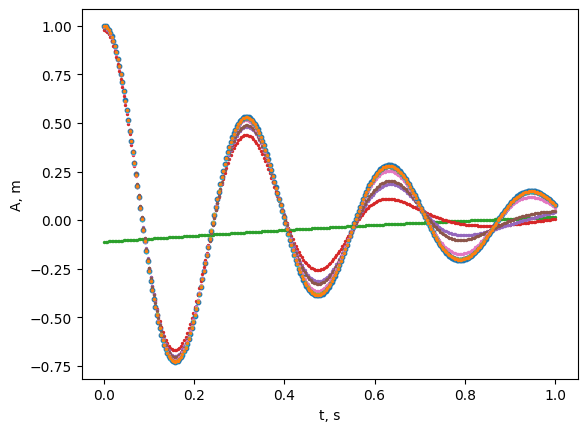

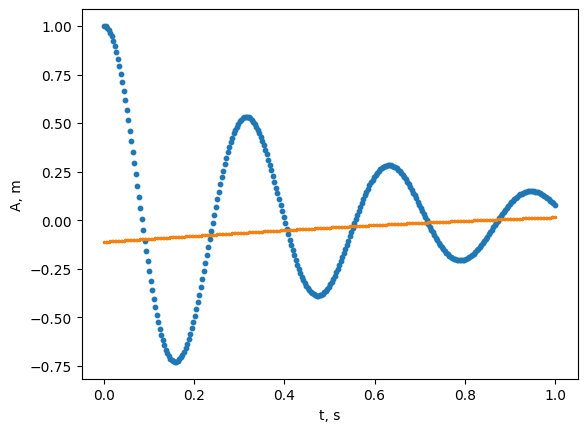

In [4]:
#%matplotlib notebook
#%matplotlib widget
t_boundary = torch.tensor(0.0).view(-1,1).requires_grad_(True).to(device)
times = torch.linspace(0,1,300).view(-1,1).requires_grad_(True).to(device)
print(f'd= {d}; w0= {w0}')
m = 1
mu,k = 2*m*d, w0**2*m
u0,v0 = 1,0
u_test = torch.zeros_like(times,device=device)
u_anal = anal(d,w0,times)

optimizer = torch.optim.Adam(pinn.parameters(), lr = 1e-3)

lambda1, lambda2 = 1e-4,1e-4
#plt.ion()
fig, ax = plt.subplots(1)
hfig = display.display(fig, display_id=True);

ax.set_xlabel('t, s')
ax.set_ylabel('A, m');

times_cpu = times.clone().detach().cpu().squeeze()
test_cpu = u_test.clone().squeeze().detach().cpu()
anals = ax.scatter(times_cpu, u_anal,s= 10)
u_current = ax.scatter(times_cpu, test_cpu,s= 2, label='current', zorder=2)
#display.clear_output(wait=True)
MAX_ITERS = 12501
for i in range(MAX_ITERS):
    optimizer.zero_grad()

    u_t0 = pinn(t_boundary)

    loss1 = (torch.squeeze(u_t0) - u0)**2

    dudt = torch.autograd.grad(u_t0, t_boundary, torch.ones_like(u_t0), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - v0)**2

    u_all = pinn(times)
    dudt = torch.autograd.grad(u_all, times, torch.ones_like(u_all), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, times, torch.ones_like(dudt), create_graph=True)[0]

    loss3 = torch.mean((d2udt2 + mu/m*dudt + k/m*u_all - 0)**2)

    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()

    optimizer.step()
    if i % 100 == 0:
        u_plot = u_all.detach().cpu().squeeze().numpy()
        u_current.set_offsets(np.vstack((times_cpu, u_plot)).T)
        if i % 1500 == 0:
            ax.scatter(times_cpu, u_plot,s= 2, label=f'iter:{i}')
            #plt.legend()
        hfig.update(fig);
        plt.pause(0.01);

plt.close()